## Part 1. Backward Induction for Hospital Environment

### 1.1. Building the hospital environment
* The hospital environment is modelled as a Markov Decision Process, including
    * Stages / Time: $t$
        * Time steps in hours
        * $t = 0, 1, 2, ..., T$
    * States: $x_t$
        * Number of patients waiting in the queue given time step
        * $x_t = 0, 1, 2, ..., \text{waiting capacity}$
    * Actions: $u_t$
        * Number of on-demand doctors to hire given time step
        * Is not defined for $t=T$ (hospital closed)
        * $u_t = 0, 1, 2, ..., \text{max number of doctors}$
    * Transitions: $f_t(x_t, u_t)$
        * Characterisation of state in next period
        * $x_{t+1}=f(x_t,u_t)=[x_t+d_t-2(u_t+10)]^+$
            * $d_t$ is the number of patients arriving in the current hour
                * Could either be a fixed number at t for a deterministic transition
                * Or follows the poisson distribution at t for a stochastic transition
            * The formula assmued hospital already has 10 permanent doctors, and each doctor on average can treat 2 patients per hour
    * Costs: $g_t, g_T$
        * Cost per Stage: $g_t(x_t, u_t)$
            * If Cost of on-demand doctor is 500/doc-hour; cost of one patient waiting per hour is 30:
                * $g_t(x_t, u_t) = 500u_t + 30x_t$
        * Terminal Cost: $g_T(x_T)$
            * If there are still patients waiting at the end of the day, the hospital will incur a cost of 300 per patient:
                * $g_T(x_T) = 300x_T$
            
        
* Detailed implementation is in class `HospitalEnv` in `hospital_env.py`


In [5]:
'''
Building the Hospital Environment
'''

from hospital_env import HospitalEnv
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

# Assume the average number of new patients coming to the hospital is known
arrival_distrib = 5 + np.array([8, 6, 5, 4, 3, 3, 4, 5, 8, 12, 16, 18,
                                19, 18, 18, 18, 19, 18, 17, 16, 16, 14, 13, 9])

# Initialize the environment
hospital_env = HospitalEnv(arrival_distrib=arrival_distrib,
                            open_time=8,
                            work_hours=12,
                            patient_waiting_cost=30,
                            doc_cost=500,
                            waiting_capacity=60,
                            max_on_demand_doc=10,
                            patient_not_treated_cost=300,
                            default_queue_length=15)

### 1.2. The Backward Induction Algorithm

* The objective:
    * Minimise the total cost:
    * $\min_{u_0,...,u_{T-1}} E\{g_1(x_1,u_1)+g_2(x_2,u_2)+...+g_{T-1}(x_{T-1},u_{T-1})+g_{T}(x_T)\}$ 
* We want to compute an Optimal Policy: $U_t(x_t)$
    * A function that maps state $x_t$ at time $t$ to action $u_t$
    * Here, the policy is represented by a matrix: 
        * `U_t[x_t, t]` gives the optimal action $u_t$ for state $x_t$ at time $t$
* Cost-to-go function: $J_t(x_t)$
    * At each state, each stage, the best decision is to choose the action that minimises the current cost plus the expected future cost.
    * So along with the policy, we need to compute a "cost-to-go" function: $J_t(x_t)$ to represent the minimal expected future cost given state $x_t$ at time $t$, given the system behave optimally for every state in the future.
    * It can be written recursively as follows (aka **Bellman's equation**):
        * $J_t(x_t) = \min_{u_t} \{g_t(x_t,u_t) + E\{J_{t+1}(f_t(x_t,u_t))\}\} \space \forall t=0,1,...,T-1$
        * $J_T(x_T) = g_T(x_T)$
    * Here, the result of $J_t$ is saved in a matrix:
        * `J_t[x_t, t]` gives the expected future cost $J_t(x_t)$ for state $x_t$ at time $t$


* The Algorithm:
    * Detail is provided in file BI_solver_det.py and BI_solver_sto.py
    * Although the stochastic environment model best simulates the real-world environment, the environment could be configured to have a fixed number of new patient coming every hour, which features a deterministic transition. Two versions of algorithms is provided repectively mainly for experimental purpose.
    * Below are some pseudo-codes that illustrate the core idea of the BI algorithm.

```
BackwardInduction:

    cost-to-go = Matrix of size: number_of_actions * number_of_stages
    optimal_policy = Matrix of size: number_of_actions * number_of_stages

    For all x_T in stage T:
        Update cost-to-go of x_T with Terminal Cost g_T

    For t <- [T - 1 .. 0]
        For all x_t in stage t:

            minimal_cost = infinity
            best_action = ?

            For all u_t in stage t, state x_t:
                future_cost = Compute the expected cost-to-go of all possible next state in next stage
                current_cost = g_t(x_t, u_t) + future_cost

                if current_cost < minimal_cost:
                    Update cost-to-go of x_t at t to current_cost
                    Update optimal_policy of x_t at t to current action u_t

                    minimal_cost = current_cost

    Return optimal_policy                             
```    
            


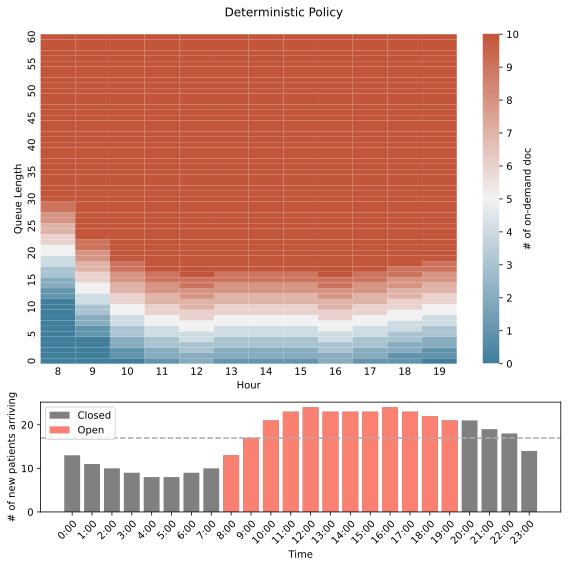

In [6]:
'''
Run the Deterministic Backward Induction Algorithm
'''

from BI_solver_det import BISolverDet


solver_det = BISolverDet(env=hospital_env)
policy_det, _ = solver_det.backward_induction()

hospital_env.visualize_policy(policy_det, "Deterministic Policy")

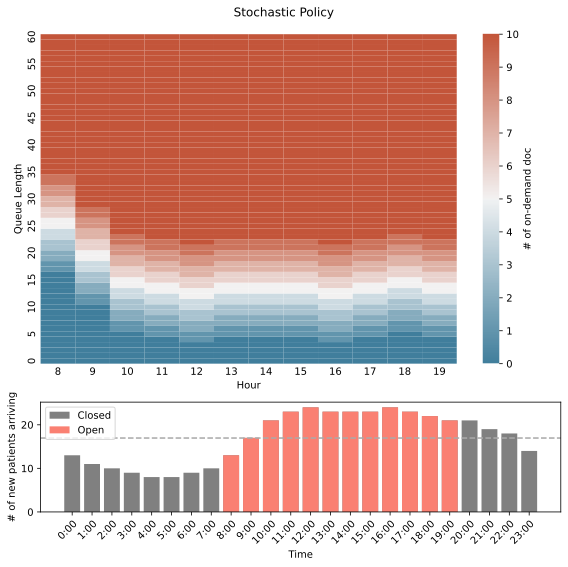

In [7]:
'''
Run the Stochastic Backward Induction Algorithm
'''

from BI_solver_sto import BISolverSto

solver_sto = BISolverSto(env=hospital_env)
policy_sto, _ = solver_sto.backward_induction()

hospital_env.visualize_policy(policy_sto, "Stochastic Policy")

### 1.3. Simulations and Performance Comparison
Performance is measured by the total cost incurred by the hospital in a day. The lower the better.
The simulation is run for 10000 times, and the average cost is reported.

* Also, a random policy is added to the comparison to set the baseline performance of knowing nothing (except all possible actions to pick from) about the environment model.

Stochastic policy:
[ Simulating for 10000 episodes... ]
Cost: 11284.56

Deterministic policy:
[ Simulating for 10000 episodes... ]
Cost: 13530.94

Random policy:
[ Simulating for 10000 episodes... ]
Cost: 21471.99


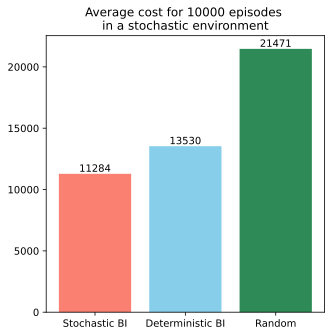

In [8]:
from tools import simulate, plot_scores

hospital_env.deterministic = False
num_ep = 10000

print("Stochastic policy:")
cost_sto = simulate(policy_sto, hospital_env, num_ep)
print(f"Cost: {cost_sto:.2f}")

print("\nDeterministic policy:")
cost_det = simulate(policy_det, hospital_env, num_ep)
print(f"Cost: {cost_det:.2f}")

# Add a random policy to set the baseline performance
print("\nRandom policy:")
policy_rand = np.random.randint(0, hospital_env.max_on_demand_doc + 1, 
                                size=(hospital_env.waiting_capacity, hospital_env.T))
cost_rand = simulate(policy_rand, hospital_env, num_ep)
print(f"Cost: {cost_rand:.2f}")


plot_scores([cost_sto, cost_det, cost_rand], 
            ["Stochastic BI", "Deterministic BI", "Random"], 
            f"Average cost for {num_ep} episodes \nin a stochastic environment")

* From the result:
    * Both BI policies reduce the cost significantly compared to the random policy.
    * The Stochastic BI outperform the Deterministic BI here, since Stochastic BI is using the exact stochastic model as the environment.

Let's put these policies into a deterministic environment. 
* Here, the simulation only need to run once for each policy, since the environment is deterministic.


Stochastic policy:
[ Simulating for 1 episodes... ]
Cost: 10480.00

Deterministic policy:
[ Simulating for 1 episodes... ]
Cost: 8300.00

Random policy:
[ Simulating for 1 episodes... ]
Cost: 32210.00


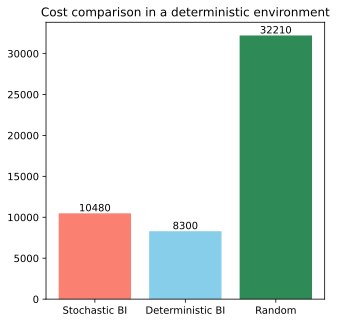

In [9]:
hospital_env.deterministic = True

print("Stochastic policy:")
cost_sto = simulate(policy_sto, hospital_env, 1)
print(f"Cost: {cost_sto:.2f}")

print("\nDeterministic policy:")
cost_det = simulate(policy_det, hospital_env, 1) 
print(f"Cost: {cost_det:.2f}")

# Add a random policy to set the baseline performance
print("\nRandom policy:")
policy_rand = np.random.randint(0, hospital_env.max_on_demand_doc + 1, 
                                size=(hospital_env.waiting_capacity, hospital_env.T))
cost_rand = simulate(policy_rand, hospital_env, 1)
print(f"Cost: {cost_rand:.2f}")


plot_scores([cost_sto, cost_det, cost_rand], 
            ["Stochastic BI", "Deterministic BI", "Random"], 
            "Cost comparison in a deterministic environment")

* From the result:
    * Again, both BI policies reduce the cost significantly compared to the random policy.
    * As expected, Deterministic BI has the lowest cost because it matches the accurate underlying model in the environment simulation.



### 1.4. Runtime Comparison and Analysis

* From the pseudo-code, we can do some runtime analysis of the algorithm:
    * If we denote the number of stages as $T$, the number of states as $X$, and the number of actions as $A$:
    * For each stage and each state, a cost-to-go is computed. So the total number of cost-to-go to compute is $TX$.
    * For the Deterministic BI, finding the best action for each state requires checking all possible actions. Since each action is only leading to one next state, the runtime is $O(TXA)$.
    * For the Stochastic BI, one action can lead to multiple next states. So the runtime is $O(TX^2A)$.
* The hospital environment above have a relatively small scope, so the BI algorithm can run in a reasonable time. 
* However, in real-world applications, the environment could be much more complex, and the BI algorithm could take a long time to run.

Let's have a look at the runtime of the BI algorithm for a larger environment.

In [10]:
from time import time


# Initialize a small environment
hospital_env_small = HospitalEnv(arrival_distrib=5 + np.array([8, 6, 5, 4, 3, 3, 4, 5, 8, 12, 16, 18,
                                                        19, 18, 18, 18, 19, 18, 17, 16, 16, 14, 13, 9]),
                            open_time=4,
                            work_hours=4,
                            patient_waiting_cost=30,
                            doc_cost=500,
                            waiting_capacity=30,
                            max_on_demand_doc=10,
                            patient_not_treated_cost=300,
                            default_queue_length=15)

# If work_hours, waiting_capacity, and max_on_demand_doc are all doubled
hospital_env_medium = HospitalEnv(arrival_distrib=5 + np.array([8, 6, 5, 4, 3, 3, 4, 5, 8, 12, 16, 18,
                                                        19, 18, 18, 18, 19, 18, 17, 16, 16, 14, 13, 9]),
                            open_time=4,
                            work_hours=8,
                            patient_waiting_cost=30,
                            doc_cost=500,
                            waiting_capacity=60,
                            max_on_demand_doc=20,
                            patient_not_treated_cost=300,
                            default_queue_length=15)

# If work_hours, waiting_capacity, and max_on_demand_doc are all doubled again
hospital_env_large = HospitalEnv(arrival_distrib=5 + np.array([8, 6, 5, 4, 3, 3, 4, 5, 8, 12, 16, 18,
                                                        19, 18, 18, 18, 19, 18, 17, 16, 16, 14, 13, 9]),
                            open_time=4,
                            work_hours=16,
                            patient_waiting_cost=30,
                            doc_cost=500,
                            waiting_capacity=120,
                            max_on_demand_doc=40,
                            patient_not_treated_cost=300,
                            default_queue_length=15)


# Run in the orginal small environment
print("Small environment:")
start = time()
solver_sto_small = BISolverSto(env=hospital_env_small)
policy_sto, _ = solver_sto_small.backward_induction()
runtime_sto = time() - start
print(f"Stochastic Backward Induction finished in {runtime_sto:.2f} s")

start = time()
solver_det_small = BISolverDet(env=hospital_env_small)
policy_det, _ = solver_det_small.backward_induction()
runtime_det = time() - start
print(f"Deterministic Backward Induction finished in {runtime_det:.2f} s")




# Run in medium size environment
print("\nMedium environment:")
start = time()
solver_sto_large = BISolverSto(env=hospital_env_medium)
policy_sto, _ = solver_sto_large.backward_induction()
runtime_sto = time() - start
print(f"Stochastic Backward Induction finished in {runtime_sto:.2f} s")

start = time()
solver_det_large = BISolverDet(env=hospital_env_medium)
policy_det, _ = solver_det_large.backward_induction()
runtime_det = time() - start
print(f"Deterministic Backward Induction finished in {runtime_det:.2f} s")



# Run in large environment
print("\nLarge environment:")
start = time()
solver_sto_large = BISolverSto(env=hospital_env_large)
policy_sto, _ = solver_sto_large.backward_induction()
runtime_sto = time() - start
print(f"Stochastic Backward Induction finished in {runtime_sto:.2f} s")

start = time()
solver_det_large = BISolverDet(env=hospital_env_large)
policy_det, _ = solver_det_large.backward_induction()
runtime_det = time() - start
print(f"Deterministic Backward Induction finished in {runtime_det:.2f} s")




Small environment:
Stochastic Backward Induction finished in 0.09 s
Deterministic Backward Induction finished in 0.00 s

Medium environment:
Stochastic Backward Induction finished in 1.32 s
Deterministic Backward Induction finished in 0.03 s

Large environment:
Stochastic Backward Induction finished in 18.86 s
Deterministic Backward Induction finished in 0.21 s


Stochastic policy:
[ Simulating for 10000 episodes... ]
Cost: 9919.27

Deterministic policy:
[ Simulating for 10000 episodes... ]
Cost: 11763.28

Random policy:
[ Simulating for 10000 episodes... ]
Cost: 126199.94


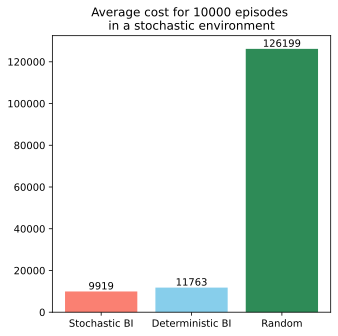

In [11]:
'''
Let's also compare the performance of the two policies
'''

hospital_env_large.deterministic = False
num_ep = 10000

print("Stochastic policy:")
cost_sto = simulate(policy_sto, hospital_env_large, num_ep)
print(f"Cost: {cost_sto:.2f}")

print("\nDeterministic policy:")
cost_det = simulate(policy_det, hospital_env_large, num_ep)
print(f"Cost: {cost_det:.2f}")

# Add a random policy to set the baseline performance
print("\nRandom policy:")
policy_rand = np.random.randint(0, hospital_env_large.max_on_demand_doc + 1, 
                                size=(hospital_env_large.waiting_capacity, hospital_env_large.T))
cost_rand = simulate(policy_rand, hospital_env_large, num_ep)
print(f"Cost: {cost_rand:.2f}")

plot_scores([cost_sto, cost_det, cost_rand],
            ["Stochastic BI", "Deterministic BI", "Random"], 
            f"Average cost for {num_ep} episodes \nin a stochastic environment")

* From the result
    * The runtime of the BI algorithm grows very fast as the number of stages, states, and actions increases.
    * The performance of Deterministic BI is still close to the Stochastic BI, but the runtime is much shorter.




### 1.5 Conclusion


#### Performance Experiment

Considering both results, we can see that the performance of the algorithm is highly dependent on how well the model the algorithm uses matches the actual model of the environment. For instance, imagine trying to develop an algorithm for predicting stock prices. If the algorithm's model only considers basic factors like historical prices and trading volume, but ignores external influences like geopolitical events or company news, its predictions might be off. This is because the stock market's behavior is influenced by myriad factors, many of which can be challenging to model accurately. Similarly, in many cases, the underlying model of the environment may be hard to define due to the environment's complexity.


#### Runtime Experiment

While the Stochastic BI can produce a better policy than the deterministic BI, it definitely take the price of a much longer runtime. The Deterministic BI could act as a good approximation if the environment is too large to run the Stochastic BI in a reasonable time.

However, such approximation algorithm that trade accuracy for speed is not always available. In the hospital environment, the poisson distribution used for transition have the highest probability at its mean value, makes it possible to approximate the expected future cost with a single value. For example, if the distrubution changes to a uniform distribution, there is not such single value to approximate the expected future cost, and the Deterministic BI will not be able to produce a good policy.


Also, in certain environments, the state space can become exceedingly large. Take the game of Go, for instance. The number of potential states is $3^{19\times19}$, an astronomically large figure. The Backward Induction algorithm, by design, calculates the cost-to-go for each state, allocating equal computational effort to every state. Given the vastness of the state space in Go, executing even the initialization step of the algorithm becomes impractical. However, in practical gameplay, many of these states have a minimal likelihood of being reached, with some being almost impossible to encounter through normal gameplays. Ideally, the algorithm should bypass these improbable states, concentrating its computational efforts on states that have a higher chance of occurring.

#### Possible(..?) Future Imporvements

How can we make the algorithm
* less depended on the model of the environment?
* search more efficiently through large state space?
